In [33]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.impute import SimpleImputer
train=pd.read_csv('/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/train.csv')
test=pd.read_csv('/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/test.csv')
rmse= pd.read_csv('/kaggle/input/country-data1/country_data.csv')
sample_submission= pd.read_csv('/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/sample_submission.csv')

In [34]:
# Drop columns from 1960 to 1999 and Unnamed: 67, 2021, 2022
columns_to_drop = [str(year) for year in range(1960, 2016)] + ['Unnamed: 67', '2021', '2022','Country Code','Indicator Name','Indicator Code']
rmse = rmse.drop(columns=columns_to_drop)


sample_submission=sample_submission.drop('2030 [YR2030]',axis =1 )

rmse['2016 [YR2016]']=rmse['2016']
rmse['2017 [YR2017]']=rmse['2017']
rmse['2018 [YR2018]']=rmse['2018']
rmse['2019 [YR2019]']=rmse['2019']
rmse['2020 [YR2020]']=rmse['2020']
rmse=rmse.drop(columns=['2016','2017','2018','2019','2020'],axis =1 )

#All country name into unique_values
unique_values = train['Country Name'].unique()
unique_values.shape

(266,)

In [35]:
train=train.drop(columns=['Country Code','Country Name'],axis =1 )
test=test.drop(columns=['Country Name'],axis =1 )

# train data 

In [36]:
import numpy as np

# Calculate the number of iterations needed
num_iterations = len(train) // 12

# List to store transposed DataFrames
transposed_dfs = []

# Iterate through the DataFrame in chunks of 12 rows
for i in range(num_iterations):
    start_idx = i * 12
    end_idx = (i + 1) * 12
    subset_df = train.iloc[start_idx:end_idx]
    transposed_subset_df = subset_df.transpose()
    transposed_dfs.append(transposed_subset_df)
    transposed_subset_df.columns = range(12)

# Concatenate the transposed DataFrames
final_df = pd.concat(transposed_dfs)

# Reset the index
final_df.reset_index(drop=True, inplace=True)




# Filter out rows containing the specified string
final_df = final_df[~final_df.apply(lambda row: 'Access to electricity (% of population)' in row.values, axis=1)]

# Reset the index after dropping rows
final_df.reset_index(drop=True, inplace=True)


column_names = [
    'Access to electricity (% of population)',
    'Agricultural land (% of land area)',
    'Annual freshwater withdrawals, total (% of internal resources)',
    'Arable land (% of land area)',
    'Forest area (% of land area)',
    'Electric power consumption (kWh per capita)',
    'Energy use (kg of oil equivalent per capita)',
    'Renewable electricity output (% of total electricity output)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Population growth (annual %)',
    'GDP per capita (current US$)',
    'CO2 emissions (metric tons per capita)'
]

# Rename columns of final_df
final_df.columns = column_names


final_df = final_df.apply(pd.to_numeric, errors='coerce')

final_df = final_df.astype(float)
final_df['Country Name'] = ''




for i in range(len(final_df) // 16):
    start_idx = i * 16
    end_idx = (i + 1) * 16
    final_df.loc[start_idx:end_idx - 1, 'Country Name'] = unique_values[i]

# drop columns 
final_df= final_df.drop(columns=[
#     'Access to electricity (% of population)',
    'Agricultural land (% of land area)', 
    'Annual freshwater withdrawals, total (% of internal resources)',                         
    'Arable land (% of land area)', 'Forest area (% of land area)',                       
    'Electric power consumption (kWh per capita)', 
    'Energy use (kg of oil equivalent per capita)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Renewable electricity output (% of total electricity output)',                   
    'Population growth (annual %)',
    'GDP per capita (current US$)'                 
                                  
                                  
                                 ],axis =1 )

# # imputed use korlam 
final_dff = final_df.drop('Country Name' , axis =1 )
imputer = SimpleImputer(strategy='mean')

final_dff = pd.DataFrame(imputer.fit_transform(final_dff), columns=final_dff.columns)

final_dff['Country Name']=final_df['Country Name']

final_df=final_dff

In [37]:
final_df.describe

<bound method NDFrame.describe of       Access to electricity (% of population)  \
0                                    4.446891   
1                                    9.294527   
2                                   14.133616   
3                                   18.971165   
4                                   23.814182   
...                                       ...   
4251                                84.624448   
4252                                85.058661   
4253                                85.816522   
4254                                86.305222   
4255                                87.022731   

      CO2 emissions (metric tons per capita) Country Name  
0                                   0.055167  Afghanistan  
1                                   0.055293  Afghanistan  
2                                   0.066810  Afghanistan  
3                                   0.073005  Afghanistan  
4                                   0.054867  Afghanistan  
...              

# DATASET MAKER CODE

/tmp/ipykernel_34/147424974.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df['CO2 emissions (metric tons per capita)'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CO2 emissions (metric tons per capita)', ylabel='Density'>

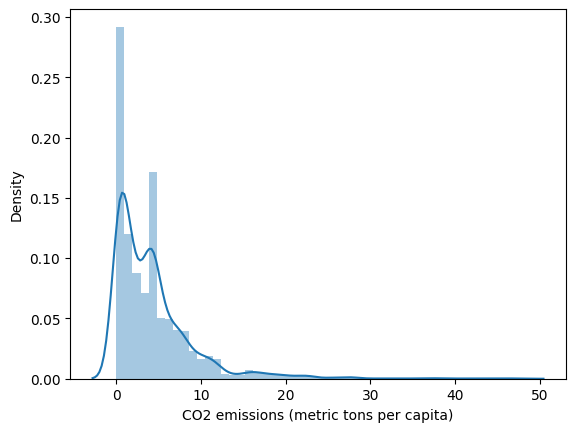

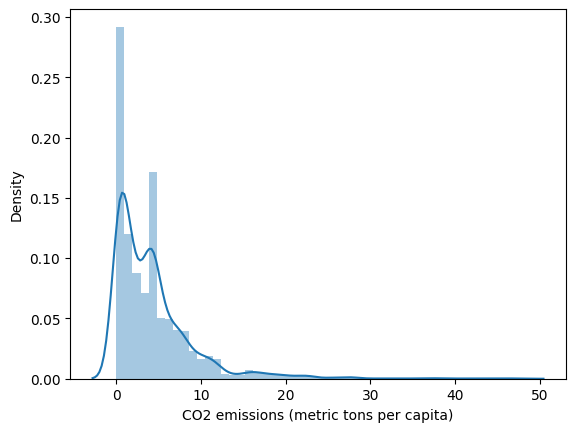

In [38]:
import seaborn as sns
sns.distplot(final_df['CO2 emissions (metric tons per capita)'])

<Axes: >

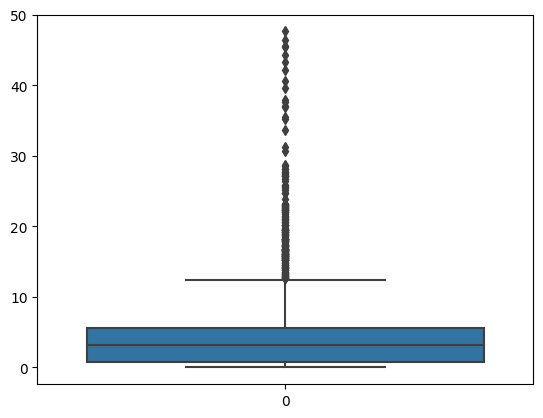

In [39]:
# to see outliers clearly
sns.boxplot(final_df['CO2 emissions (metric tons per capita)'])

# Z - score for CO2 emissions (metric tons per capita)

In [42]:
# find the limit
upper_limit = final_df['CO2 emissions (metric tons per capita)'].mean()+3*final_df['CO2 emissions (metric tons per capita)'].std()
lower_limit = final_df['CO2 emissions (metric tons per capita)'].mean()-3*final_df['CO2 emissions (metric tons per capita)'].std()
print('Upper limit: ', upper_limit)
print('Lower limit: ', lower_limit)

Upper limit:  19.173575976221183
Lower limit:  -10.662839843477983


In [43]:
# find the outliers
final_df.loc[(final_df['CO2 emissions (metric tons per capita)']>upper_limit) | (final_df['CO2 emissions (metric tons per capita)']<lower_limit)]

,Access to electricity (% of population),CO2 emissions (metric tons per capita),Country Name
224,100.0,22.315944,Bahrain
225,100.0,22.439114,Bahrain
226,100.0,23.013401,Bahrain
227,100.0,23.056822,Bahrain
228,100.0,21.509723,Bahrain
...,...,...,...
4017,100.0,19.790637,North America
4018,100.0,19.173837,North America
4019,100.0,19.276691,North America
4020,100.0,19.318091,North America


In [44]:
# # trimming - delete the outliers data
# new_df = final_df.loc[(final_df['CO2 emissions (metric tons per capita)']<upper_limit) & (final_df['CO2 emissions (metric tons per capita)']>lower_limit)]
# print('before removing outliers: ', len(final_df))
# print('after removing outliers: ', len(new_df))

In [45]:
# capping - change the outliers value according upper ar lower limit
new_df = final_df.copy()
new_df.loc[new_df['CO2 emissions (metric tons per capita)']>upper_limit,'CO2 emissions (metric tons per capita)'] = upper_limit
new_df.loc[new_df['CO2 emissions (metric tons per capita)']<lower_limit,'CO2 emissions (metric tons per capita)'] = lower_limit


<Axes: >

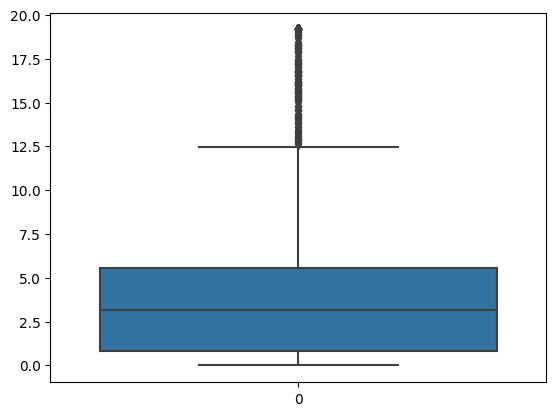

In [46]:
sns.boxplot(new_df['CO2 emissions (metric tons per capita)'])

In [47]:
len(new_df)

4256

# Z - score for Access to electricity (% of population)

In [48]:
# find the limit
upper_limit = new_df['Access to electricity (% of population)'].mean()+3*new_df['Access to electricity (% of population)'].std()
lower_limit = new_df['Access to electricity (% of population)'].mean()-3*new_df['Access to electricity (% of population)'].std()
print('Upper limit: ', upper_limit)
print('Lower limit: ', lower_limit)

Upper limit:  167.13311972770612
Lower limit:  -10.56162291541348


In [49]:
# find the outliers
new_df.loc[(new_df['Access to electricity (% of population)']>upper_limit) | (new_df['Access to electricity (% of population)']<lower_limit)]

,Access to electricity (% of population),CO2 emissions (metric tons per capita),Country Name


In [50]:
# # trimming - delete the outliers data
# df = new_df.loc[(new_df['Access to electricity (% of population)']<upper_limit) & (new_df['Access to electricity (% of population)']>lower_limit)]
# print('before removing outliers: ', len(new_df))
# print('after removing outliers: ', len(df))

In [51]:
# capping - change the outliers value according upper ar lower limit
df = new_df.copy()
df.loc[df['Access to electricity (% of population)']>upper_limit,'Access to electricity (% of population)'] = upper_limit
df.loc[df['Access to electricity (% of population)']<lower_limit,'Access to electricity (% of population)'] = lower_limit


<Axes: >

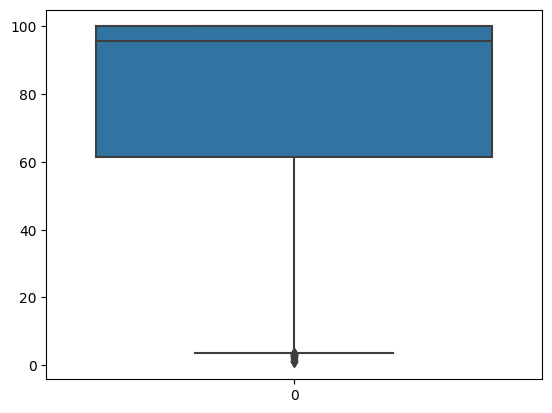

In [52]:
sns.boxplot(df['Access to electricity (% of population)'])

## IQR method outliers detection for CO2 emissions (metric tons per capita)

/tmp/ipykernel_34/4173809850.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df['Access to electricity (% of population)'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Access to electricity (% of population)', ylabel='Density'>

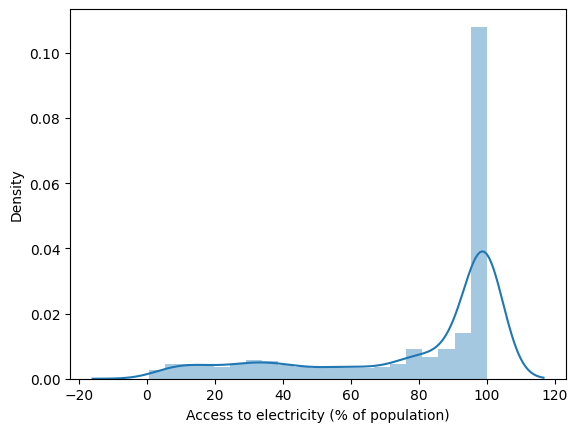

In [53]:
sns.distplot(final_df['Access to electricity (% of population)'])

<Axes: >

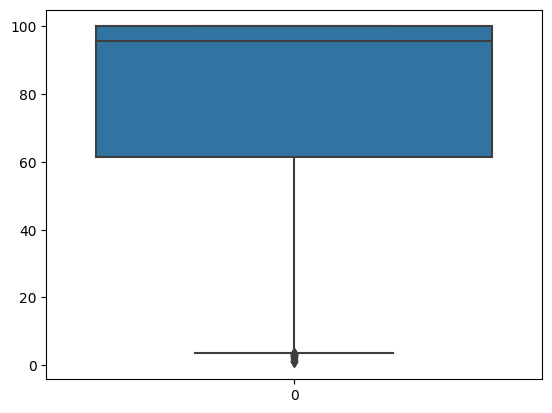

In [54]:
# to see outliers clearly
sns.boxplot(final_df['Access to electricity (% of population)'])

In [55]:
final_df = df

# Test data 

In [56]:
import numpy as np

# Calculate the number of iterations needed
num_iterations = len(test) // 11

# List to store transposed DataFrames
transposed_dfs = []

# Iterate through the DataFrame in chunks of 11 rows
for i in range(num_iterations):
    start_idx = i * 11
    end_idx = (i + 1) * 11
    subset_df = test.iloc[start_idx:end_idx]
    transposed_subset_df = subset_df.transpose()
    transposed_dfs.append(transposed_subset_df)
    transposed_subset_df.columns = range(11)

# Concatenate the transposed DataFrames
final_test_df = pd.concat(transposed_dfs)

# Reset the index
final_test_df.reset_index(drop=True, inplace=True)






# Filter out rows containing the specified string
final_test_df = final_test_df[~final_test_df.apply(lambda row: 'Access to electricity (% of population)' in row.values, axis=1)]

# Reset the index after dropping rows
final_test_df.reset_index(drop=True, inplace=True)






column_names = [
    'Access to electricity (% of population)',
    'Agricultural land (% of land area)',
    'Annual freshwater withdrawals, total (% of internal resources)',
    'Arable land (% of land area)',
    'Forest area (% of land area)',
    'Electric power consumption (kWh per capita)',
    'Energy use (kg of oil equivalent per capita)',
    'Renewable electricity output (% of total electricity output)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Population growth (annual %)',
    'GDP per capita (current US$)',
]

# Rename columns of final_df
final_test_df.columns = column_names


final_test_df = final_test_df.apply(pd.to_numeric, errors='coerce')

final_test_df = final_test_df.astype(float)
final_test_df['Country Name'] = ''






for i in range(len(final_test_df) // 5):
    start_idx = i * 5
    end_idx = (i + 1) * 5
    final_test_df.loc[start_idx:end_idx - 1, 'Country Name'] = unique_values[i]

# drop columns 
final_test_df = final_test_df.drop(columns=[
#     'Access to electricity (% of population)',
    'Agricultural land (% of land area)', 
    'Annual freshwater withdrawals, total (% of internal resources)',                         
    'Arable land (% of land area)', 'Forest area (% of land area)',                       
    'Electric power consumption (kWh per capita)', 
    'Energy use (kg of oil equivalent per capita)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Renewable electricity output (% of total electricity output)',                   
    'Population growth (annual %)',
    'GDP per capita (current US$)'                 
],axis =1 )



# imputed use korlam 
final_dff = final_test_df.drop('Country Name' , axis =1 )
imputer = SimpleImputer(strategy='mean')
final_dff = pd.DataFrame(imputer.fit_transform(final_dff), columns=final_dff.columns)

final_dff['Country Name']=final_test_df['Country Name']

final_test_df=final_dff


In [60]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Create an empty dictionary to store RMSE values
rmse_values = {}

# Iterate over each row in the sample_submission DataFrame
for index, row in sample_submission.iterrows():
    # Extract country name
    country_name = row['Country Name']
    
    # Extract predicted values from the sample_submission DataFrame
    predicted_values = row[['2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]']]
    
    # Locate the corresponding row in the rmse DataFrame
    real_values_row = rmse[rmse['Country Name'] == country_name]
    
    # Ensure there is a corresponding row in the rmse DataFrame
    if not real_values_row.empty:
        # Extract real values for years 2016 to 2020
        real_values = real_values_row.iloc[:, 1:].values.squeeze()
        
        # Calculate RMSE only if real_values is not empty
        if not np.isnan(real_values).all():
            # Calculate RMSE
            rmse_value = np.sqrt(mean_squared_error(real_values, predicted_values))
            
            # Store RMSE value in the dictionary
            rmse_values[country_name] = rmse_value

# Convert the dictionary to a DataFrame
rmse_df = pd.DataFrame(list(rmse_values.items()), columns=['Country Name', 'RMSE'])


In [61]:
# Calculate the average RMSE
average_rmse = rmse_df['RMSE'].mean()

print("Average RMSE:", average_rmse)


Average RMSE: 0.4431701448459627


In [59]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define a dictionary to store the model fit for each country
model_fits = {}

# Iterate over unique countries
for country in unique_values:
    # Filter data for the current country
    afg = final_df[final_df['Country Name'] == country].drop('Country Name', axis=1)
    
    # Extract features and target variable
    country_data = afg.drop(columns=['CO2 emissions (metric tons per capita)']).astype(float)
    co2_emissions = afg['CO2 emissions (metric tons per capita)'].astype(float)
    
    test_data_country = final_test_df[final_test_df['Country Name'] == country].drop('Country Name', axis=1)
    
    try:
        # Check if the model has already been fitted for this country
        if country in model_fits:
            # Use the previous model fit's order to fine-tune the model
            model_fit = model_fits[country]
            order = model_fit.model_orders
        else:
            # Otherwise, start with an initial order of (2, 1, 1)
            order = (1, 1, 0)
        
        # Train the ARIMA model with both columns as exogenous variables
        model = ARIMA(co2_emissions, exog=country_data, order=order)
        model_fit = model.fit()
        
        # Regularization: Apply Ridge regularization to the coefficients
        alpha = 0.1  # Regularization strength
        
        # Apply Ridge regularization to the coefficients
        model_fit.params[1:] *= (1 - alpha)
        
        # Update the model fit for the current country
        model_fits[country] = model_fit
        
        # Forecast CO2 emissions using the test data as exogenous variables
        forecast = model_fits[country].forecast(steps=5, exog=test_data_country)

        # Check if all forecast values are zero
        if all(value == 0 for value in forecast) and all(value == 0 for value in forecast1):
            continue  # Skip this country if all forecast values are zero
        
        # Find the row index in the sample_submission DataFrame
        row_index = sample_submission[sample_submission.eq(country).any(axis=1)].index[0]
        
        # Update the sample_submission DataFrame with the forecast values
        new_values = [country, forecast[16], forecast[17], forecast[18], forecast[19], forecast[20]]
        sample_submission.loc[row_index] = new_values
    except Exception as e:
        print(f"Error occurred for {country}: {e}")


/tmp/ipykernel_34/2952678003.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  model_fit.params[1:] *= (1 - alpha)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provi

In [34]:
# sample_submission.to_csv('final_sort_drop3_nan_col.csv', index=False)